# Reddit Wall Street Comment Analysis

### Import the required packages

In [1]:
# import the package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import datetime
#Used to tally stock mentions
from collections import Counter

# These commands below set some options for pandas and to have matplotlib show the charts in the notebook
pd.set_option('display.max_rows', 1000)
pd.options.display.float_format = '{:,.2f}'.format
%matplotlib inline

# Define a date parser to pass to read_csv
d = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
d1 = lambda x: pd.datetime.strptime(x, '%m/%d/%Y')
d2 = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
d3 = lambda x: pd.datetime.strptime(x, '%m/%d/%y')


### Read the csv file and sanity check for data

In [2]:
# read the CSV file. Also, parse the timestamp column as a date field
df_orig = pd.read_csv('./Data/reddit_wsb.csv', index_col=False, parse_dates=['timestamp'], date_parser=d)
print(df_orig.shape)

<ipython-input-1-6b02be003f58>:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  d = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')


(43880, 8)


In [3]:
# Sanity Check to know the data types
df_orig.dtypes

title                object
score                 int64
id                   object
url                  object
comms_num             int64
created             float64
body                 object
timestamp    datetime64[ns]
dtype: object

In [4]:
# Sanity Check to know the columns
df_orig.columns

Index(['title', 'score', 'id', 'url', 'comms_num', 'created', 'body',
       'timestamp'],
      dtype='object')

In [5]:
# print first few rows to check
df_orig.head(2)

,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,"1,611,862,661.00",NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,"1,611,862,330.00",NaN,2021-01-28 21:32:10


### Create a copy of the dataframe and filter contents from 2021 only

In [6]:
# Create a copy of the dataframe with the datetime required. Also, we will drop unwanted column from the new frame
df = df_orig.copy()[df_orig['timestamp'] >= datetime.datetime(2021, 1, 1)]

In [7]:
#df.head(2)
# check to validate the data consistency
#df.loc[df['url'] == "https://www.reddit.com/r/wallstreetbets/comments/l7x6j1/gamestop_big_picture_the_short_singularity_pt_3/"]
#df[df_orig['url'] == "https://www.reddit.com/r/wallstreetbets/comments/l7x6j1/gamestop_big_picture_the_short_singularity_pt_3/"]
#df[df_orig['url'] == "https://www.reddit.com/r/wallstreetbets/comments/ljgtxj/mvis_shiny_laser_go_pew_no_but_seriously_they_are/"]

In [8]:
# Check if there are any rows with both body and text as NaN
#df[(df['body'].isnull()) & (df['title'].isnull())]

# Check if Title is NaN -- There is no value matching the criteria
#df[(df['title'].isnull())]

# Check if Score is NaN -- There is no value matching the criteria
#df[(df['score'].isnull())]

# Check if comms_num is Nan -- There is no value matching the criteria
#df[(df['comms_num'].isnull())]

# Check if timestamp is NaN -- There is no value matching the criteria
#df[(df['timestamp'].isnull())]

# Check if body is NaN -- There are rows matching
#df[(df['body'].isnull())]

# Replace all NaN values with ""
df = df.fillna("")

### Create new date column and drop the other unnecessary columns from the dataframe

In [9]:
# Create a new column which has date only and remove time component
df['just_date'] = df['timestamp'].dt.date
df['text'] = df['title'] + ' ' + df['body']

# Delete the columns not required for our use
df = df.drop(columns = ['body','title'])
del(df['id'])
del(df['url'])
del(df['created'])
del(df['timestamp'])

In [10]:
#df1 = df_orig.copy()[df_orig['timestamp'] >= datetime.datetime(2021, 1, 1)]
#print(df1['timestamp'].min())
#print(df1['timestamp'].max())

# Check the Min and Max Date

print(df['just_date'].min())
print(df['just_date'].max())
#print("---- Unique value of date")
#df['just_date'].unique()

2021-01-28
2021-03-30


In [11]:
# Rearrange the column in the dataframe
df = df[['just_date', 'text', 'score', 'comms_num']]

In [12]:
df.head(5)
#print(df.shape)

,just_date,text,score,comms_num
0,2021-01-28,"It's not about the money, it's about sending a...",55,6
1,2021-01-28,Math Professor Scott Steiner says the numbers ...,110,23
2,2021-01-28,Exit the system The CEO of NASDAQ pushed to ha...,0,47
3,2021-01-28,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,74
4,2021-01-28,"Not to distract from GME, just thought our AMC...",71,156


### Read a file which has a list of all the ticker symbol

In [13]:
#Pulling stock tickers from text file, reading the txt file in csv format
stock_symbols = pd.read_csv("./Data/all_symbols.txt")
#Creating list of stock tickers from contents in txt file using the first entry 'A' as
list_of_stocks = stock_symbols['A'].to_list()
# Remove the commonly used words
words = ["AN",'IMO', 'VERY', 'ANY', 'GOOD', 'MUST', 'EVER', 'HUGE', 'ITM',"THE","OF","AND","A","TO","IN","IS","YOU","THAT","IT","HE","WAS","FOR","ON","ARE","AS","WITH","HIS","THEY","I","MY","THAN","FIRST","WATER","BEEN","CALL","WHO","OIL","ITS","NOW","FIND","LONG","DOWN","DAY","DID","GET","COME","MADE","MAY","PART","SOME","HER","WOULD","MAKE","LIKE","HIM","INTO","TIME","HAS","LOOK","TWO","MORE","WRITE","GO","SEE","NUMBER","NO","WAY","COULD","PEOPLE","THERE","USE","AN","EACH","WHICH","SHE","DO","HOW","THEIR","IF","WILL","UP","OTHER","ABOUT","OUT","MANY","THEN","THEM","THESE","SO","AT","BE","THIS","HAVE","FROM","OR","ONE","HAD","BY","WORD","BUT","NOT","WHAT","ALL","WERE","WE","WHEN","YOUR","CAN","SAID", "CEO", "HOLD", "DD", "BUY", "RH", "YOLO", "JUST", "AM", "NAKD", "NEED", "EDIT", "BIG", "IPO", 'WANT', 'LOVE']
    
for element in list_of_stocks:
    if element in words or len(element) == 1:
        list_of_stocks.remove(element)

# Check the total stock count and sanity check the stock list
print(len(list_of_stocks))
#print(list_of_stocks)
# 7483


7421


### Create new column to hold the ticker symbols of stocks which the users have commented. Also, iterate through the stock_list to identify the stock symbols which users have commented and add it to the repository against the row.

In [14]:
# Create a empty column to the dataframe to hold the list of stocks listed by users in text field earlier
df["stk_list"] = "[]"

In [15]:
# iterating over rows using iterrows() function 
# This will check if the ticker symbol exists as part of the text column and create a list of
# all the tickers present. It would be collected as a list and updated in the stk_list for each row
# This takes time to complete, around 7 minute.
#for index, row in df.head(5).iterrows():
for index, row in df.iterrows():
    list1=[]
    col_value=row["text"]
    #Remove all the characters except alphabets and space
    whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    clean_value = ''.join(filter(whitelist.__contains__, col_value))
    # Convet the converted string into list and split at space
    clean_list = clean_value.split()
    #print(index,row["text"])
    for ticker in list_of_stocks:
        if ticker in clean_list:
            list1.append(ticker)
            #print("Ticker present", ticker)
    #print("The stock list", list1)
    #df.loc[index, 'stk_list'] = list1
    df.at[index,'stk_list'] = list1
    #print("-----------------------------------")

In [16]:
# Sanity Check the dataframe after previous command is complete
df.head(5)

,just_date,text,score,comms_num,stk_list
0,2021-01-28,"It's not about the money, it's about sending a...",55,6,[]
1,2021-01-28,Math Professor Scott Steiner says the numbers ...,110,23,[]
2,2021-01-28,Exit the system The CEO of NASDAQ pushed to ha...,0,47,[GME]
3,2021-01-28,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,74,[GME]
4,2021-01-28,"Not to distract from GME, just thought our AMC...",71,156,"[AMC, GME]"


### Create Dictionary to hold the unique list of stocks which has been commented for the respective day. Key is Date, Value is list of stock

In [17]:
# Loop through the dataframe and create a dictionary having date as key and stock list as value
# This takes around 2 minute to complete
dict_stk_list={}

# Delete the rows from dataframe where there are no stocks mentioned as part of the stk_list
#for index, row in df.head(5).iterrows():
for index, row in df.iterrows(): # looping through dataframe
    # extract the stock list of the row into a variable
    val=row['stk_list']
    # delete the row if the stock list is empty
    if len(val) == 0:
        df.drop(index, inplace = True)
    else:
        # get the date of the row
        v_date=row['just_date']
        # check if the date exists in dictionary
        if v_date in dict_stk_list: # date exists in dictionary
            # date exists, hence append value to the list of the values already present in key
            ## get the values already associated to key
            key_value=dict_stk_list[v_date]
            ## remove the single character values from the dataframe list
            val = [x for x in val if len(x) > 1]
            ## combine the data to create new list and sort it
            ###combine_value=(key_value + list(set(val) - set(key_value)))
            combine_value=key_value + val
            combine_value.sort()
            ## update the final list to dictionary
            dict_stk_list[v_date] = combine_value
            #print("updated_dict", dict_stk_list[v_date])
        else: # if date does not exist then add a new entry to dictionary
            ## remove the single character values from the dataframe list
            val = [x for x in val if len(x) > 1]
            dict_stk_list[v_date] = val
        
        




### Group by and get the sum of score and Comments for each day

In [18]:
# Group by on the date and sum the score and comment column value
v_output=df.groupby("just_date")["score", "comms_num"].sum()
# resetting the index
v_output = v_output.reset_index(drop=False)
# removing the time and keeping only date
v_output['just_date']= pd.to_datetime(v_output['just_date'])
v_output['just_date'] = v_output['just_date'].dt.date
#v_output.dtypes
#v_output
#df.groupby(['country', 'month'])['revenue', 'profit', 'ebit'].sum()

<ipython-input-18-26d9857da6f8>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  v_output=df.groupby("just_date")["score", "comms_num"].sum()


### Append the stock list from dictionary to the dataframe having grouped value
v_output dataframe has the output in required format

In [19]:
# Create a empty column to the dataframe to hold the list of stocks listed by users in text field earlier
v_output["stk_list"] = "[]"
#v_output.head(5)
# append the stock list
for index, row in v_output.iterrows():
    val_date=row['just_date']
    # check if this date exists in dictionary
    if val_date in dict_stk_list:
        #print("date exists", val_date, dict_stk_list[val_date])
        v_output.at[index,'stk_list'] = dict_stk_list[val_date]
    else:
        print("date does not exist", val_date)
v_output.head(5)




,just_date,score,comms_num,stk_list
0,2021-01-28,348330,39486,"[AA, AA, AAL, AAL, AAL, AAL, AAL, AAL, AAL, AA..."
1,2021-01-29,1637952,320624,"[AA, AA, AA, AA, AA, AAL, AAL, AAL, AAL, AAL, ..."
2,2021-01-30,2642393,375733,"[AAL, AAL, AAL, AAPL, AAPL, AAPL, AAPL, AAPL, ..."
3,2021-01-31,1325253,140407,"[AAPL, AAPL, AAPL, AAPL, AAPL, AB, AB, ABC, AC..."
4,2021-02-01,1614000,232770,"[AA, AAL, AAL, AAPL, AAPL, AAPL, AAPL, AC, ACT..."


### Exploratory

In [20]:
#Create Large List of total mentions from Jan 28 to March 31st
full_list =[]
x =0
for x in range(0, len(v_output)):
    full_list += v_output.iloc[x][3]
    
#Create Dictionary of counts of each stock mention
temp_dic = Counter(full_list)

#full_list

In [ ]:
#Sort Dictionary and then delete least remaining mentions
sorted_dic = sorted(temp_dic.items(), key = lambda x : x[1], reverse = True)

#Total the number of mentions
total_mentions = 0
for item in sorted_dic:
    total_mentions += item[1]


#Delete all occurences except for top 100 stocks that are mentioned
top_list = []
for tuple in sorted_dic:
    if tuple[1]>29:
        top_list.append(tuple)
print(len(top_list))  
#top_list

#Create keys and values for plotting
symbols =[]
mentions =[]
[symbols.append(tuple[0]) for tuple in top_list]
[mentions.append(tuple[1]) for tuple in top_list]

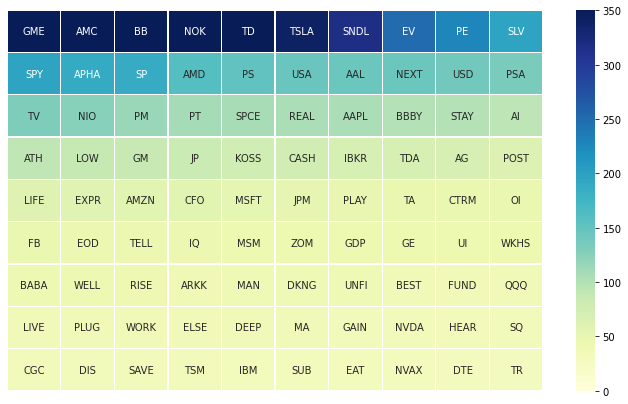

In [22]:
#Create HeatMap
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,7))
#Create Array
symbols_array = ((np.asarray(symbols))).reshape(9,10)
mentions_array = ((np.asarray(mentions))).reshape(9,10)
#Creat heatmap, with left and bottom ticks removed
sns.heatmap(mentions_array, annot = symbols_array, fmt = '',cmap = 'YlGnBu', robust = True, vmin =0, vmax = 350, linewidth =.3)
ax.tick_params(left = False, bottom = False, labelbottom = False, labelleft =False)

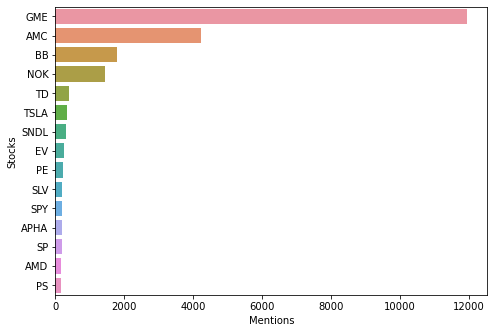

In [23]:
#Plot Bar chart of all stocks mentioned and number of occurences
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
sns.barplot(x = mentions[:15], y = symbols[:15],  orient = 'h')
ax.set_xlabel('Mentions')
ax.set_ylabel('Stocks')
plt.show()

In [24]:
#Create days of week list
days_list = ['Thurs', 'Fri', 'Sat', 'Sun', 'Mon','Tue','Wed']*8 + ['Thurs','Fri', 'Sat','Sun','Mon','Tue']
len(days_list)

62

/Users/ryangoding/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


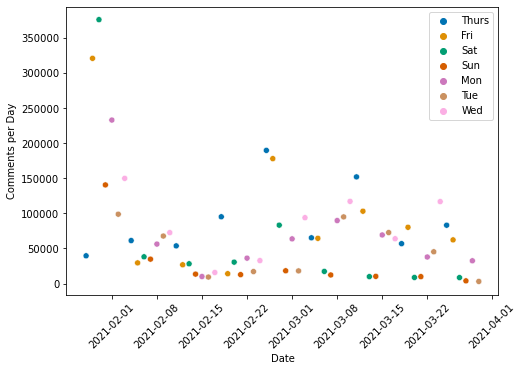

In [25]:
#Create Scatter Plot for comments as time goes on
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
sns.scatterplot(v_output['just_date'].array,v_output['comms_num'].array, hue = days_list, palette='colorblind')
plt.xticks(rotation = 45)
ax.set_xlabel('Date')
ax.set_ylabel('Comments per Day')

plt.show()

/Users/ryangoding/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


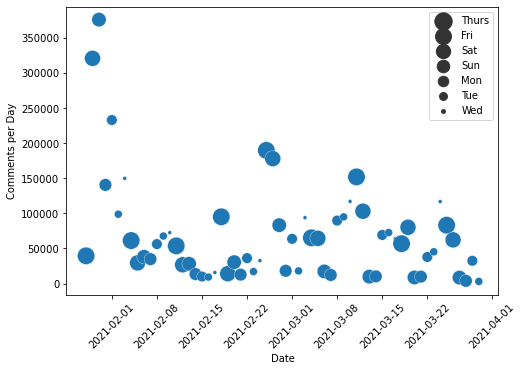

In [26]:
#Create Scatter Plot for comments as time goes on
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
sns.scatterplot(v_output['just_date'].array,v_output['comms_num'].array, size = days_list, sizes = (15,300), palette='colorblind')
plt.xticks(rotation = 45)
ax.set_xlabel('Date')
ax.set_ylabel('Comments per Day')

plt.show()

In [27]:
#install wordcloud
#!pip install wordcloud

In [28]:
#Create large string for wordcloud
test_string =''
for element in full_list:
    test_string += element +' '


In [29]:
#Create wordcloud
from wordcloud import WordCloud
wordcloud = WordCloud(width = 1300, height = 800, background_color ='salmon', colormap='Pastel2', collocations = False).generate(test_string)

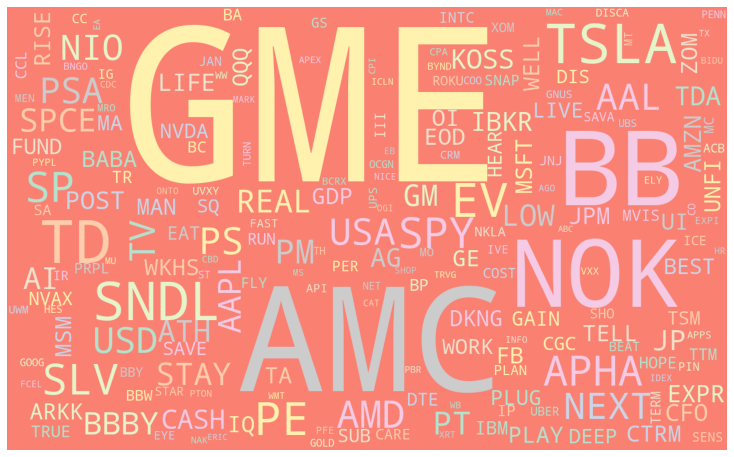

In [30]:
#Plt wordcloud
plt.figure(figsize = (10,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

### Import Data from S&P 500, GME and AMC

In [31]:
# Create Dataframe for GME and AMC seperately
# Extract the content of S&P in to a dataframe
#snp = pd.read_csv('./Data/INDEX_US_S&P US_SPX.csv', index_col=False, parse_dates=['Date'], date_parser=d1)
snp = pd.read_csv('./Data/S&P500Index.csv', index_col=False, parse_dates=['Date'], date_parser=d3)
#snp.head(5)

# Extract the content of GME in to a dataframe
gme = pd.read_csv('./Data/GME.csv', index_col=False, parse_dates=['Date'], date_parser=d2)
#gme.head(5)

# Extract the content of AMC in to a dataframe
amc = pd.read_csv('./Data/AMC.csv', index_col=False, parse_dates=['Date'], date_parser=d2)
#amc.head(5)

snp.head(5)
#v_output.head(5)
#v_output.dtypes

<ipython-input-1-6b02be003f58>:19: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  d3 = lambda x: pd.datetime.strptime(x, '%m/%d/%y')
<ipython-input-1-6b02be003f58>:18: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  d2 = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')


,Date,Open,High,Low,Close,AdjClose,Volume
0,2021-03-30,"3,963.34","3,968.01","3,944.35","3,958.55","3,958.55","4,103,570,000.00"
1,2021-03-29,"3,969.31","3,981.83","3,943.25","3,971.09","3,971.09","4,619,840,000.00"
2,2021-03-26,"3,917.12","3,978.19","3,917.12","3,974.54","3,974.54","5,467,850,000.00"
3,2021-03-25,"3,879.34","3,919.54","3,853.50","3,909.52","3,909.52","4,940,800,000.00"
4,2021-03-24,"3,919.93","3,942.08","3,889.07","3,889.14","3,889.14","4,766,990,000.00"


### Graph to show the trend of User Comment and Effect on SPYIndex over the time period

Text(0, 0.5, 'S&P 500 Index')

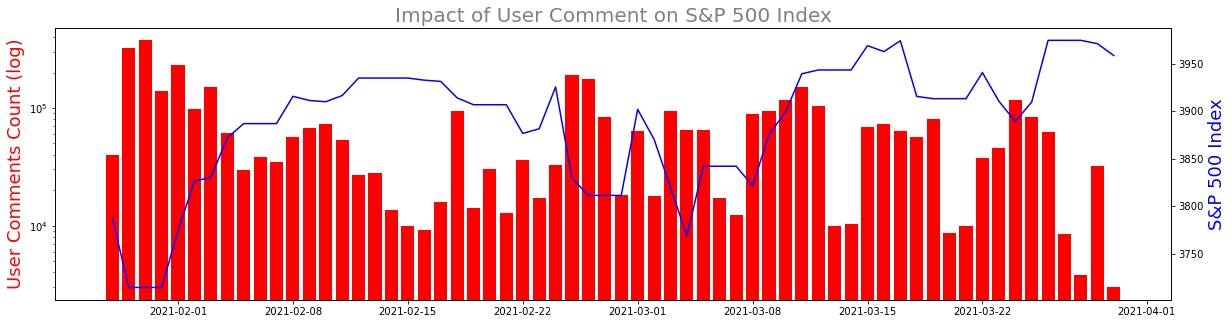

In [32]:
## Code for generating the graph
# Create a new df for user content
user_data=v_output.copy()
# convert the date column to datetime type
user_data['just_date'] = pd.to_datetime(user_data['just_date'])
# rename the column value
user_data.rename(columns={"just_date": "Date"}, inplace = True)
# Join with the S&P dataframe to get its value
user_data=user_data.merge(snp, on='Date', how='left')

# For the values which have nan, update the S&P500 to its previous value.
# This is done because the values are nan for Weekend, hence we need to pick the value of Friday
for index, row in user_data.iterrows():
    if pd.isnull(row["Close"]):
        user_data.loc[index, 'Close'] = prev_val
    else:
        prev_val = row["Close"]
#user_data
# Plot the Graph
plt.figure(1, figsize=(20,5))
plt.title('Impact of User Comment on S&P 500 Index', fontsize=20, color='grey')
plt.bar(user_data['Date'], user_data['comms_num'], color='red', log=True)

plt.ylabel('User Comments Count (log)', fontsize=18, color='red')
plt.twinx()
plt.plot(user_data['Date'], user_data['Close'], color='blue',label='Sum')
plt.ylabel('S&P 500 Index', fontsize=18, color='blue')


### Prepare the GME Dataframe for Analysis

In [33]:
# GME - Final Column: Date, STOCK_PRICE, VOLUME, ETF_PRICE, SCORE, COMMENT
df_gme = gme.copy()
# drop the columns not required
df_gme = df_gme.drop(columns = ['Open','High', 'Low', 'Adj Close'])
# Merge the GME and SPY
df_gme=df_gme.merge(snp, on='Date', how='outer')
# drop the columns not required and rename the other column value
df_gme = df_gme.drop(columns = ['Open','High', 'Low', 'AdjClose'])
df_gme.rename(columns={"Close_x": "StockPrice", "Close_y": "SPYIndex", "Volume_x": "StockVolume", "Volume_y": "SPYIndexVolume"}, inplace = True)


# copy the wsb v_output dataframe for rows having GME in it
df_gme_wallstreet = v_output.copy()[v_output['stk_list'].astype(str).str.contains("GME")]
# drop the columns not required
df_gme_wallstreet = df_gme_wallstreet.drop(columns = ['stk_list'])
# rename the column just_date to Date and also convert the column to datetime datatype value
df_gme_wallstreet.rename(columns={"just_date": "Date", "comms_num": "CommentCount"}, inplace = True)
df_gme_wallstreet['Date'] = pd.to_datetime(df_gme_wallstreet['Date'])
# Merge the GME, SPY and WallStreet Data
df_gme=df_gme.merge(df_gme_wallstreet, on='Date', how='left')
df_gme = df_gme.fillna(0)

#print(df_gme.dtypes)
#df_gme.set_index('Date', inplace=True)
#df_gme.head(5)

### Data for GME

here I want to do something because my index is DatetimeIndex


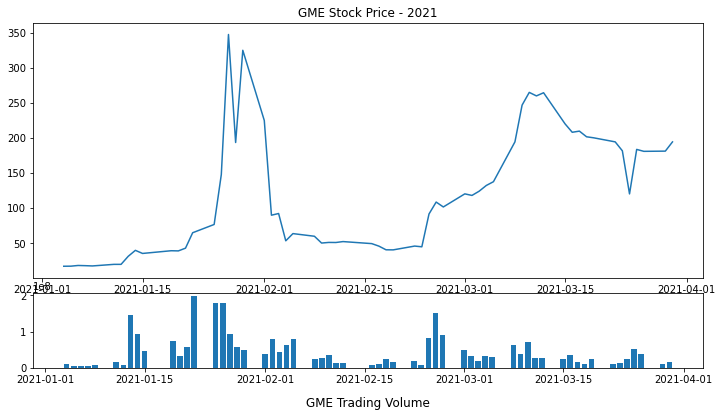

In [34]:
# Copy the gme dataframe
df_gme_1=gme.copy()
df_gme_1.dtypes
#df_gme_1['Date'].astype('str')
#df_gme_1.dtypes
stock_data = df_gme_1.set_index('Date')
#stock_data.index = stock_data.index.map(str)
stock_data.head()
if isinstance(stock_data.index, pd.core.indexes.datetimes.DatetimeIndex): 
    print('here I want to do something because my index is DatetimeIndex')
top_plt = plt.subplot2grid((5,4), (0, 0), rowspan=3, colspan=4)
top_plt.plot(stock_data.index, stock_data["Close"])
plt.title('GME Stock Price - 2021')
bottom_plt = plt.subplot2grid((5,4), (3,0), rowspan=1, colspan=4)
bottom_plt.bar(stock_data.index, stock_data['Volume'])
plt.title('\nGME Trading Volume', y=-0.60)
plt.gcf().set_size_inches(12,8)

### Comparing the GME StockPrice and CommentCount

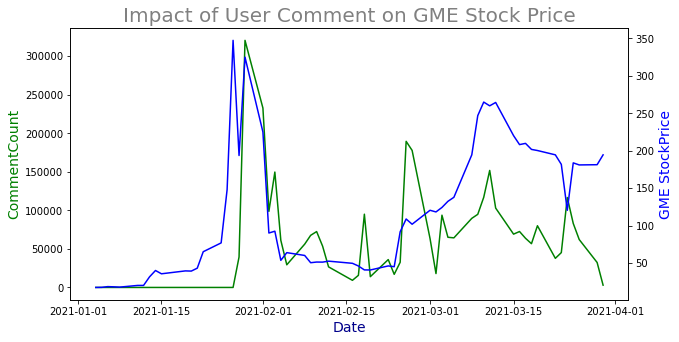

In [35]:
## Graph for Checking the correlation between StockPrice and CommentCount for GME
import matplotlib.pyplot as plt
df_pr_cmt = df_gme[['Date', 'StockPrice', 'CommentCount']].copy()

# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(10,5))
# make a plot
ax.plot(df_pr_cmt.Date, df_pr_cmt.CommentCount, color="green")
# set x-axis label
ax.set_xlabel("Date", color="darkblue", fontsize=14)
# set y-axis label
ax.set_ylabel("CommentCount",color="green",fontsize=14)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df_pr_cmt.Date, df_pr_cmt["StockPrice"],color="blue")
ax2.set_ylabel("GME StockPrice",color="blue",fontsize=14)
ax.set_title("Impact of User Comment on GME Stock Price", color="grey", fontsize=20)
plt.show()

### Draw a graph to show the comparison of GME Price and S&P


Text(0, 0.5, 'S&P 500 Index')

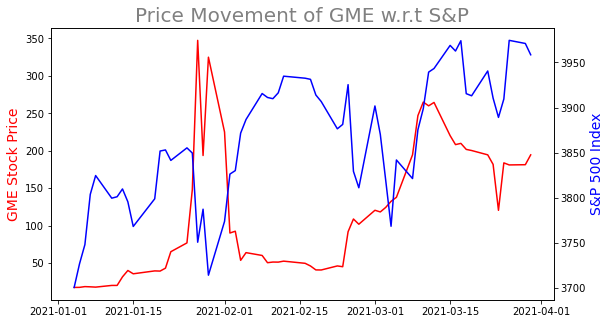

In [36]:
plt.figure(1, figsize=(9,5))
plt.title('Price Movement of GME w.r.t S&P', fontsize=20, color='grey')
plt.plot(df_gme['Date'], df_gme['StockPrice'], color='red')
plt.ylabel('GME Stock Price', fontsize=14, color='red')
plt.twinx()
plt.plot(df_gme['Date'], df_gme['SPYIndex'], color='blue',label='Sum')
plt.ylabel('S&P 500 Index', fontsize=14, color='blue')


### Draw a graph to show the comparison of GME Volume and Comment Count

Text(0, 0.5, 'Comments Count')

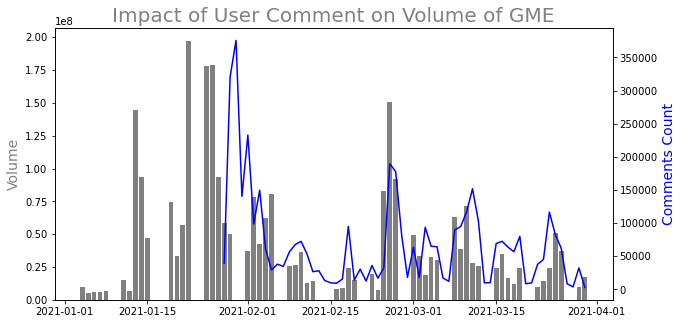

In [37]:
#plt.figure(1, figsize=(18,7))
#plt.title('Price Movement of GME w.r.t S&P', fontsize=20, color='grey')
#plt.plot(df_gme['Date'], df_gme['StockPrice'], color='red')
#plt.ylabel('GME Stock Price', fontsize=18, color='red')
#plt.twinx()
#plt.plot(df_gme['Date'], df_gme['SPYIndex'], color='blue',label='Sum')
#plt.ylabel('S&P 500 Index', fontsize=18, color='blue')

# Create a new df for user content
user_data_1=v_output.copy()
# convert the date column to datetime type
user_data_1['just_date'] = pd.to_datetime(user_data_1['just_date'])
# rename the column value
user_data_1.rename(columns={"just_date": "Date"}, inplace = True)
# Join with the GME dataframe to get its value
user_data_1=user_data_1.merge(gme, on='Date', how='outer')

# For the values which have nan, update the S&P500 to its previous value.
# This is done because the values are nan for Weekend, hence we need to pick the value of Friday
for index, row in user_data_1.iterrows():
    if pd.isnull(row["Close"]):
        user_data_1.loc[index, 'Close'] = prev_val
    else:
        prev_val = row["Close"]


plt.figure(1, figsize=(10,5))
plt.title('Impact of User Comment on Volume of GME', fontsize=20, color='grey')
plt.bar(user_data_1['Date'], user_data_1['Volume'], color='grey', log=False)

plt.ylabel('Volume', fontsize=14, color='grey')
plt.twinx()
plt.plot(user_data_1['Date'], user_data_1['comms_num'], color='blue',label='Sum')
plt.ylabel('Comments Count', fontsize=14, color='blue')

#df_gme.head(50)
#user_data_1.head(5)


### Comparing the AMC Stock Price and Comment Count

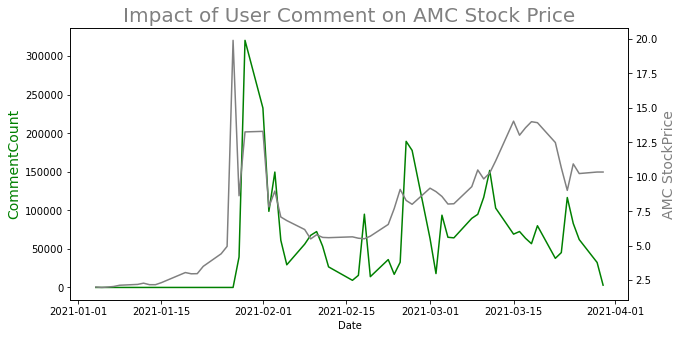

In [38]:
# AMC - Final Column: Date, STOCK_PRICE, VOLUME, ETF_PRICE, SCORE, COMMENT
df_amc = amc.copy()
# drop the columns not required
df_amc = df_amc.drop(columns = ['Open','High', 'Low', 'Adj Close'])
# Merge the AMC and SPY
df_amc=df_amc.merge(snp, on='Date', how='outer')
# drop the columns not required and rename the other column value
df_amc = df_amc.drop(columns = ['Open','High', 'Low', 'AdjClose'])
df_amc.rename(columns={"Close_x": "StockPrice", "Close_y": "SPYIndex", "Volume_x": "StockVolume", "Volume_y": "SPYIndexVolume"}, inplace = True)


# copy the wsb v_output dataframe for rows having AMC in it
df_amc_wallstreet = v_output.copy()[v_output['stk_list'].astype(str).str.contains("AMC")]
# drop the columns not required
df_amc_wallstreet = df_amc_wallstreet.drop(columns = ['stk_list'])
# rename the column just_date to Date and also convert the column to datetime datatype value
df_amc_wallstreet.rename(columns={"just_date": "Date", "comms_num": "CommentCount"}, inplace = True)
df_amc_wallstreet['Date'] = pd.to_datetime(df_amc_wallstreet['Date'])
# Merge the GME, SPY and WallStreet Data
df_amc=df_amc.merge(df_amc_wallstreet, on='Date', how='left')
df_amc = df_amc.fillna(0)
#df_amc.head(5)

# For creating the plot of AMC
df_pr_cmt_amc = df_amc[['Date', 'StockPrice', 'CommentCount']].copy()
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(10,5))
# make a plot
ax.plot(df_pr_cmt_amc.Date, df_pr_cmt_amc.CommentCount, color="green")
# set x-axis label
ax.set_xlabel("Date")
# set y-axis label
ax.set_ylabel("CommentCount",color="green",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df_pr_cmt_amc.Date, df_pr_cmt_amc["StockPrice"],color="grey")
ax2.set_ylabel("AMC StockPrice",color="grey",fontsize=14)
ax.set_title("Impact of User Comment on AMC Stock Price", color="grey", fontsize=20)
plt.show()

### Calculate the average user comments per day of week

Text(0.5, 1.0, 'Average Comments on Day of Week')

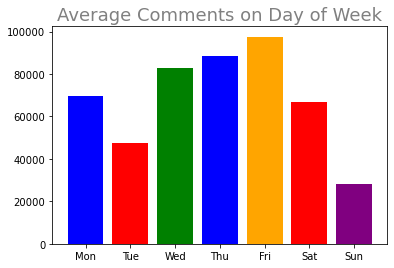

In [39]:
import numpy as np
import datetime
import statistics

df_day_of_week=v_output.copy()
df_day_of_week['just_date'] = pd.to_datetime(df_day_of_week['just_date'])
df_day_of_week.dtypes

# Create Dictionary to hold the value
#dict_wd = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0}
dict_wd={}
# loop through dataframe
avg_val=0
for index, row in df_day_of_week.iterrows():
    date1=row["just_date"]
    date1 = np.datetime64(date1)
    day = date1.astype(datetime.datetime).isoweekday()
    # check if the day exists in dictionary
    if day in dict_wd: # day exists in dictionary
        # append the value to list
        dict_wd[day].append(row["comms_num"])
    else: # if date does not exist then add a new entry to dictionary
        dict_wd[day] = [row["comms_num"]]
# Update the Key value
dict_wd["Mon"] = dict_wd.pop(1)
dict_wd["Tue"] = dict_wd.pop(2)
dict_wd["Wed"] = dict_wd.pop(3)
dict_wd["Thu"] = dict_wd.pop(4)
dict_wd["Fri"] = dict_wd.pop(5)
dict_wd["Sat"] = dict_wd.pop(6)
dict_wd["Sun"] = dict_wd.pop(7)

# calculate the average
for key, value in dict_wd.items():
    dict_wd[key]=round(statistics.mean(value))

# extract the keys and values for plot
keys = dict_wd.keys()
values = dict_wd.values()
# plot
plt.bar(keys, values, color=['blue', 'red', 'green', 'blue', 'orange', 'red', 'purple'])
plt.title("Average Comments on Day of Week", fontsize=18, color="grey")



### Analyzing data for NOK and BB

In [40]:
# Create Dataframe for NOK and BB seperately
# Extract the content of S&P in to a dataframe
snp = pd.read_csv('./Data/INDEX_US_S&P US_SPX.csv', index_col=False, parse_dates=['Date'], date_parser=d1)
#snp.head(5)

# Extract the content of NOK in to a dataframe
nok = pd.read_csv('./Data/NOK.csv', index_col=False, parse_dates=['Date'], date_parser=d2)
#gme.head(5)

# Extract the content of BB in to a dataframe
bb = pd.read_csv('./Data/BB.csv', index_col=False, parse_dates=['Date'], date_parser=d2)
#amc.head(5)


# Final Column: Date, STOCK_PRICE, VOLUME, ETF_PRICE, SCORE, COMMENT
df_nok = nok.copy()
# drop the columns not required
df_nok = df_nok.drop(columns = ['Open','High', 'Low', 'Adj Close'])
#df_nok.head(5)
# Merge the NOK and SPY
df_nok=df_nok.merge(snp, on='Date', how='outer')
# drop the columns not required and rename the other column value
df_nok = df_nok.drop(columns = ['Open','High', 'Low'])
df_nok.rename(columns={"Close_x": "StockPrice", "Close_y": "SPYIndex"}, inplace = True)
# copy the wsb v_output dataframe for rows having NOK in it
df_nok_wallstreet = v_output.copy()[v_output['stk_list'].astype(str).str.contains("NOK")]
# drop the columns not required
df_nok_wallstreet = df_nok_wallstreet.drop(columns = ['stk_list'])
# rename the column just_date to Date and also convert the column to datetime datatype value
df_nok_wallstreet.rename(columns={"just_date": "Date", "comms_num": "CommentCount"}, inplace = True)
df_nok_wallstreet['Date'] = pd.to_datetime(df_nok_wallstreet['Date'])
# Merge the NOK, SPY and WallStreet Data
df_nok=df_nok.merge(df_nok_wallstreet, on='Date', how='left')
# df_nok.head(500)
# adding percentage change column to show increase or decrease from day to day
df_nok['% Change in Comments'] = df_nok['CommentCount'].pct_change()
df_nok['% Change in Comments'] = df_nok['CommentCount'].pct_change().round(2)
#percent change of Stock price change from day to day
df_nok['Stock Price % Change'] = df_nok['StockPrice'].pct_change()
df_nok['Stock Price % Change'] = df_nok['StockPrice'].pct_change().round(2)
df_nok = df_nok.fillna(0)
df_nok = df_nok.sort_values(by="Date")
df_nok = df_nok.drop(range(56,60))
# df_nok.dtypes
#Date       datetime64[ns]
#df_nok_wallstreet.dtypes
# join the dataframes
# df_nok

<ipython-input-1-6b02be003f58>:17: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  d1 = lambda x: pd.datetime.strptime(x, '%m/%d/%Y')
<ipython-input-1-6b02be003f58>:18: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  d2 = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')


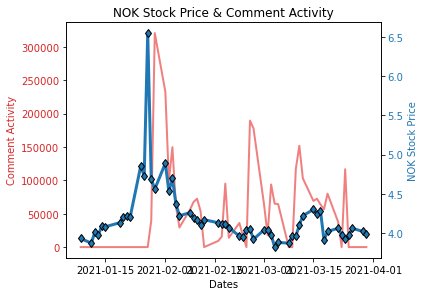

In [41]:
#Creating plot comparing comment activity and NOK stock prices 
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Dates')
ax1.set_ylabel('Comment Activity', color=color)
ax1.plot(df_nok['Date'], df_nok['CommentCount'], color='lightcoral', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
# instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('NOK Stock Price', color=color)
ax2.plot(df_nok['Date'], df_nok['StockPrice'], color=color, linewidth=3, marker='d', markeredgecolor='black')
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
ax1.grid(False)
plt.title('NOK Stock Price & Comment Activity')
plt.show()

### BB stock dataframe creation

In [42]:
df_bb = bb.copy()
df_bb = df_bb.drop(columns = ['Open','High', 'Low', 'Adj Close'])
df_bb=df_bb.merge(snp, on='Date', how='outer')
df_bb = df_bb.drop(columns = ['Open','High', 'Low'])
df_bb.rename(columns={"Close_x": "StockPrice", "Close_y": "SPYIndex"}, inplace = True)
df_bb_wallstreet = v_output.copy()[v_output['stk_list'].astype(str).str.contains("BB")]
df_bb_wallstreet = df_bb_wallstreet.drop(columns = ['stk_list'])
df_bb_wallstreet.rename(columns={"just_date": "Date", "comms_num": "CommentCount"}, inplace = True)
df_bb_wallstreet['Date'] = pd.to_datetime(df_bb_wallstreet['Date'])
df_bb=df_bb.merge(df_bb_wallstreet, on='Date', how='left')
# adding percentage change column to show increase or decrease from day to day
df_bb['% Change in Comments'] = df_bb['CommentCount'].pct_change()
df_bb['% Change in Comments'] = df_bb['CommentCount'].pct_change().round(2)
#percent change of Stock price change from day to day
df_bb['Stock Price % Change'] = df_bb['StockPrice'].pct_change()
df_bb['Stock Price % Change'] = df_bb['StockPrice'].pct_change().round(2)
df_bb = df_bb.fillna(0)
df_bb = df_bb.sort_values(by="Date")
df_bb = df_bb.drop(range(57,60))
##df_bb

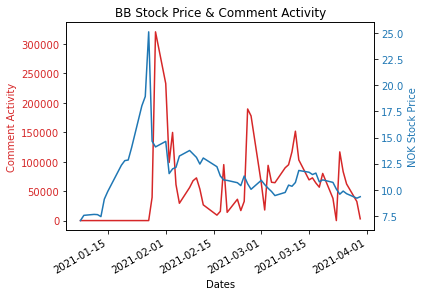

In [43]:
#Creating plot comparing comment activity and NOK stock prices 
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Dates')
ax1.set_ylabel('Comment Activity', color=color)
ax1.plot(df_bb['Date'], df_bb['CommentCount'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('NOK Stock Price', color=color)  # we already handled the x-label with ax1
ax2.plot(df_bb['Date'], df_bb['StockPrice'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.autofmt_xdate()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.grid(False)
plt.title('BB Stock Price & Comment Activity')
plt.show()

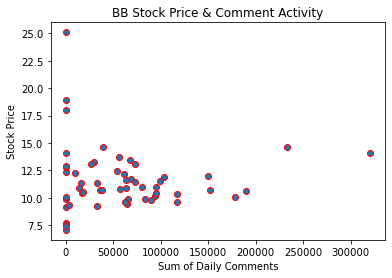

In [44]:
#Scatter plot correlating comment activity and stock price
plt.scatter(df_bb['CommentCount'], df_bb['StockPrice'], edgecolors='r')
plt.xlabel('Sum of Daily Comments')
plt.ylabel('Stock Price')
plt.title('BB Stock Price & Comment Activity')
plt.show()

### Comparision of comment activity & SPYIndex

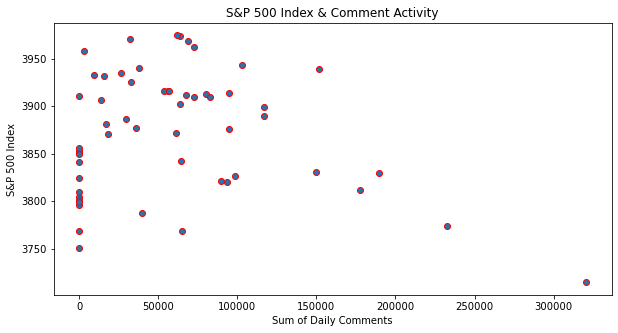

In [45]:
#Type checking the SPYindex
# df_bb.dtypes
#Converting Spy index from object to float
df_bb['SPYIndex'] = df_bb['SPYIndex'].apply(lambda x: float(x.split()[0].replace(',', '')))
#Sanity Checking type change
# df_bb.dtypes
# df_bb['CommentCount'].describe()
#Scatter plot correlating comment activity and Spy Index
plt.figure(1, figsize=(10,5))
plt.scatter(df_bb['CommentCount'], df_bb['SPYIndex'], edgecolors='r')
plt.xlabel('Sum of Daily Comments')
plt.ylabel('S&P 500 Index')
plt.title('S&P 500 Index & Comment Activity')
plt.show()